https://www.kaggle.com/learn/feature-engineering
user count feature

# start

In [1]:
PRFX='0324_6_2'
trntmstmp=1584412344
valtmstmp=1585069785
import datetime
print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (trntmstmp, valtmstmp)])

grand_total=1.5e8
MIN_TM_TRN=1580947200
MIN_TM_TST=1581552000
print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (MIN_TM_TRN, MIN_TM_TST)])


CHNKSZ=5e6
POST_RATE_WANTED=0.1

['2020-03-17 02:32:24', '2020-03-24 17:09:45']
['2020-02-06 00:00:00', '2020-02-13 00:00:00']


# setup

In [2]:
from pathlib import Path
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import pickle
from tqdm import tqdm
from collections import Counter
import category_encoders as ce
pd.set_option('display.max_rows', 500)

from functools import reduce
import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

SEED=101
HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# https://towardsdatascience.com/how-to-calibrate-undersampled-model-scores-8f3319c1ea5b
# How to use the function?
# Let’s say your goal is to generate a model that shows the credit default probabilities and your original 
# training data has 50,000 rows with only 500 of them labeled as target class. When you sample your non-target 
# instances randomly and reduce the total row count to 10,000, while conserving 500 target rows, our calibration
# function becomes:
# calibration(model_results, 50000, 500, 10000, 500)
# Here model_results is your model probability output array. After you train your model and put the results in it, your function is ready to use. 

def calibration(data, train_pop, target_pop, sampled_train_pop, sampled_target_pop):
    calibrated_data = \
    ((data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)) /
    ((
        (1 - data) * (1 - target_pop / train_pop) / (1 - sampled_target_pop / sampled_train_pop)
     ) +
     (
        data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)
     )))

    return calibrated_data

cols=[
'toks',
'hshtgs',
'twtid',
'media',
'links',
'domns',
'twttyp',
'lang',
'tm',

'u1id',
'u1_fllwer_cnt',
'u1_fllwng_cnt',
'u1_vrfed',
'u1_create_tm',

'u2id',
'u2_fllwer_cnt',
'u2_fllwng_cnt',
'u2_vrfed',
'u2_create_tm',

'u1_fllw_u2',
'reply_tm',
'retwt_tm',
'retwt_cmmnt_tm',
'like_tm',
]
cols_cat = ['twttyp','lang']
cols_val = cols[:-4]
cols_tgt_tmstmp=[
    'retwt_tm',
    'reply_tm',
    'like_tm',
    'retwt_cmmnt_tm',
]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
ntgts=len(tgts)


tgt2col=dict(zip(tgts,cols_tgt))
tgt2col

{'Retweet': 'retwt',
 'Reply': 'reply',
 'Like': 'like',
 'RTwCmnt': 'retwt_cmmnt'}

# prepare data

## prep func

In [3]:
# chnks_trn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',
#                     header=None,names=cols, 
#                         chunksize=CHNKSZ)
# # first chunk as validate data
# for ichnk,df in enumerate(chnks_trn):
#     df
#     break

# istrn=True
# tm_min = MIN_TM_TRN if istrn else MIN_TM_TST
# df['len_toks'] = df.toks.apply(len)
# for media in ['Photo', 'Video', 'GIF']:
#     df[f'has_media_{media}'] = df.media.fillna('').apply(lambda x: media in x)
# for col in ['hshtgs', 'links', 'domns',]:
#     df[f'num_{col}'] = df[col].fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0)

# df['twt_age'] = df.tm - tm_min
# df['u1_age']  = df.tm - df.u1_create_tm
# df['u2_age']  = df.tm - df.u2_create_tm

# tm_dt=pd.to_datetime(df.tm, unit='s')
# df['tm_dayofweek']=tm_dt.dt.dayofweek
# df['tm_hour']=tm_dt.dt.hour

# df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm

# df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
# df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age

# for col in ['twttyp','lang']:
#     df[col]=df[col].astype('category')

# ce_features = ['twttyp', 'lang' ]
# cnt_encd = ce.CountEncoder()
# cnt_encded = cnt_encd.fit_transform(df[ce_features])
# cnt_encded = cnt_encded.astype(int)
# cnt_encded.columns = [f'{col}_cnt' for col in ce_features]

# df = pd.concat([df,cnt_encded],1)

# if istrn: 
#     df[cols_tgt]=df[cols_tgt_tmstmp].notna().astype('int8')
#     df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns',  
#                                    'tm', 'u1_create_tm','u2_create_tm', 'u1id', 'u2id', 'twtid', ]+cols_tgt_tmstmp, )
# else:
#     df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 
#                                    'tm', 'u1_create_tm','u2_create_tm', 'u1id', ])   

# df.dtypes

In [4]:
def prp_df(df, istrn=True):
    tm_min = MIN_TM_TRN if istrn else MIN_TM_TST
    df['len_toks'] = df.toks.apply(len)
    for media in ['Photo', 'Video', 'GIF']:
        df[f'has_media_{media}'] = df.media.fillna('').apply(lambda x: media in x)
    for col in ['hshtgs', 'links', 'domns',]:
        df[f'num_{col}'] = df[col].fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0)

    df['twt_age'] = df.tm - tm_min
    df['u1_age']  = df.tm - df.u1_create_tm
    df['u2_age']  = df.tm - df.u2_create_tm

    tm_dt=pd.to_datetime(df.tm, unit='s')
    df['tm_dayofweek']=tm_dt.dt.dayofweek
    df['tm_hour']=tm_dt.dt.hour

    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm

    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age

    for col in cols_cat:
        df[col]=df[col].astype('category')

    df['u1u2']=df.u1id+'_'+df.u2id
    ce_features = ['twttyp', 'lang', 'u1id', 'u2id', 'u1u2', 'twtid']
    cnt_encd = ce.CountEncoder()
    cnt_encded = cnt_encd.fit_transform(df[ce_features])
    cnt_encded = cnt_encded.astype(int)
    cnt_encded.columns = [f'{col}_cnt' for col in ce_features]

    df = pd.concat([df,cnt_encded],1)
    if istrn: 
        df[cols_tgt]=df[cols_tgt_tmstmp].notna().astype('int8')
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns',  
                                       'tm', 'u1_create_tm','u2_create_tm', 'u1id', 'u1u2', 'u2id', 'twtid', ]+cols_tgt_tmstmp, )
    else:
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 
                                       'tm', 'u1_create_tm','u2_create_tm', 'u1id', 'u1u2'])   
    return df

In [5]:
grand_total, grand_total/CHNKSZ

(150000000.0, 30.0)

## valid data

In [6]:
chnks_trn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',
                    header=None,names=cols, 
                        chunksize=CHNKSZ)
# first chunk as validate data
for ichnk,df in enumerate(chnks_trn):
    print(dtnow(), 'chunk', ichnk)
#     print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') 
#            for o in (df.tm.min(), df.tm.max())])
    dfvalid = prp_df(df)
    break
print('dfvalid.shape:',dfvalid.shape)

cols_feat=[o for o in dfvalid.columns if o not in cols_tgt]

display(dfvalid[cols_feat].dtypes)

2020-03-25 02:12:23 chunk 0


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


dfvalid.shape: (5000000, 34)


twttyp                  category
lang                    category
u1_fllwer_cnt              int64
u1_fllwng_cnt              int64
u1_vrfed                    bool
u2_fllwer_cnt              int64
u2_fllwng_cnt              int64
u2_vrfed                    bool
u1_fllw_u2                  bool
len_toks                   int64
has_media_Photo             bool
has_media_Video             bool
has_media_GIF               bool
num_hshtgs                 int64
num_links                  int64
num_domns                  int64
twt_age                    int64
u1_age                     int64
u2_age                     int64
tm_dayofweek               int64
tm_hour                    int64
tmdlta_u2u1                int64
u1_fllwer_cnt_by_age     float64
u1_fllwng_cnt_by_age     float64
twttyp_cnt                 int64
lang_cnt                   int64
u1id_cnt                   int64
u2id_cnt                   int64
u1u2_cnt                   int64
twtid_cnt                  int64
dtype: obj

## trnval data func

In [7]:
def getdftrvl(tgt):
    print(tgt)
    tgtcol=tgt2col[tgt]
    chnks_trn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',
                        header=None,names=cols, 
                            chunksize=CHNKSZ)
    len_df_wanted = int(CHNKSZ)
    # retwt          0.113031
    # reply          0.027488
    # like           0.439499
    # retwt_cmmnt    0.007742
    pos_rate_wanted = POST_RATE_WANTED
    n_pos_wanted = int(len_df_wanted*pos_rate_wanted)
    print('n_pos_wanted', n_pos_wanted)
    np.random.seed(SEED)
    lst_df = []
    n_pos_ttl = 0
    for ichnk,df in enumerate(chnks_trn):
        #skip first chunk (it was validate data)
        if ichnk==0: continue
        print(dtnow(), 'chunk', ichnk)
        df = prp_df(df)
        n_pos_ttl+= df[tgtcol].sum()
        lst_df.append(df)
        if n_pos_ttl>=n_pos_wanted: break

    df = pd.concat(lst_df)
    df.reset_index(drop=True,inplace=True)


    # https://stackoverflow.com/questions/28556942/pandas-remove-rows-at-random-without-shuffling-dataset
    idx_neg=np.where(df[tgtcol]==0)[0]
    n_neg = len(idx_neg)
    n_pos = len(df)-len(idx_neg)
    n_neg2keep = len_df_wanted-n_pos
    n_neg2rmv = n_neg-n_neg2keep
    idx_neg2rmv = np.random.choice(idx_neg, n_neg2rmv, replace=False)
    dftrvl = df.drop(idx_neg2rmv)
    dftrvl = dftrvl.sample(len(dftrvl))
    for col in cols_cat:
        dftrvl[col]=dftrvl[col].astype('category')
    
#     display(dftrvl.dtypes)
    print('dftrvl.shape:',dftrvl.shape,'dftrvl[tgtcol].mean():',dftrvl[tgtcol].mean())
    
    pops={
        'train_pop':len(df),
        'target_pop':n_pos,
        'sampled_train_pop':len_df_wanted,
        'sampled_target_pop':n_pos,
    }
    print(pops)
    return dftrvl, pops

# model

In [8]:
def train(params,dtr,dvl):
    print(params)
    evals_result = {}
    evallist = [(dtr, 'train'), (dvl, 'eval')]
    bst = lgb.train(params=params, 
                    train_set=dtr, 
                    num_boost_round=5000,
                    valid_sets=[dtr, dvl],
                    verbose_eval=100,
                    early_stopping_rounds=100,
                    evals_result=evals_result,
                   )
    return bst,evals_result

def valid(bst,dftr,dfvl):
    prdtr = bst.predict(dftr[cols_feat],num_iteration=bst.best_iteration)
    prdvl = bst.predict(dfvl[cols_feat],num_iteration=bst.best_iteration)
    return prdtr,prdvl

def do_tgt(tgt):
    params=tgt2params[tgt]
    tgtcol=tgt2col[tgt]
    dftrvl, pops=getdftrvl(tgt)
    split=int(len(dftrvl)*0.85)
    dftr,dfvl=dftrvl[:split],dftrvl[split:]
    dtr = lgb.Dataset(dftr[cols_feat], label=dftr[tgtcol])
    dvl = lgb.Dataset(dfvl[cols_feat], label=dfvl[tgtcol])
    bst,evlres=train(params,dtr,dvl)
    prdtr,prdvl=valid(bst,dftr,dfvl)
    
    tgt2bst[tgt]=bst
    tgt2evlres[tgt]=evlres
    tgt2ytr[tgt]=dftr[tgtcol]
    tgt2yvl[tgt]=dfvl[tgtcol]
    tgt2pops[tgt]=pops
    tgt2prdtr[tgt]=prdtr
    tgt2prdvl[tgt]=prdvl


In [9]:
params_shared = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": 0,
    "boosting_type": "gbdt",
}
tgt2params = {k:params_shared for k in tgts}

tgt2bst={}
tgt2evlres={}
tgt2tuning_history={}
tgt2ytr={}
tgt2yvl={}
tgt2prdtr={}
tgt2prdvl={}
tgt2pops={}
for tgt in tgts:
    print(dtnow(), tgt, '*'*80)
    do_tgt(tgt)
    
pickle.dump(tgt2bst, open(f"{p_out}/tgt2bst.p", "wb"))

2020-03-25 02:14:19 Retweet ********************************************************************************
Retweet
n_pos_wanted 500000
2020-03-25 02:17:03 chunk 1
dftrvl.shape: (5000000, 34) dftrvl[tgtcol].mean(): 0.1131548
{'train_pop': 5000000, 'target_pop': 565774, 'sampled_train_pop': 5000000, 'sampled_target_pop': 565774}
{'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': 0, 'boosting_type': 'gbdt'}
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.302181	valid_1's binary_logloss: 0.30265
[200]	training's binary_logloss: 0.299357	valid_1's binary_logloss: 0.300359
[300]	training's binary_logloss: 0.297819	valid_1's binary_logloss: 0.299399
[400]	training's binary_logloss: 0.296618	valid_1's binary_logloss: 0.298756
[500]	training's binary_logloss: 0.295527	valid_1's binary_logloss: 0.298232
[600]	training's binary_logloss: 0.294524	valid_1's binary_logloss: 0.297764
[700]	training's binary_logloss: 0.293626	valid_1's b

[700]	training's binary_logloss: 0.543601	valid_1's binary_logloss: 0.548162
[800]	training's binary_logloss: 0.542358	valid_1's binary_logloss: 0.547401
[900]	training's binary_logloss: 0.541248	valid_1's binary_logloss: 0.546765
[1000]	training's binary_logloss: 0.540244	valid_1's binary_logloss: 0.546225
[1100]	training's binary_logloss: 0.53928	valid_1's binary_logloss: 0.545755
[1200]	training's binary_logloss: 0.538414	valid_1's binary_logloss: 0.545351
[1300]	training's binary_logloss: 0.537517	valid_1's binary_logloss: 0.544919
[1400]	training's binary_logloss: 0.536661	valid_1's binary_logloss: 0.544531
[1500]	training's binary_logloss: 0.535836	valid_1's binary_logloss: 0.544176
[1600]	training's binary_logloss: 0.534974	valid_1's binary_logloss: 0.543817
[1700]	training's binary_logloss: 0.534245	valid_1's binary_logloss: 0.54356
[1800]	training's binary_logloss: 0.533601	valid_1's binary_logloss: 0.543387
[1900]	training's binary_logloss: 0.532786	valid_1's binary_logloss: 

# analyze

## tr vl

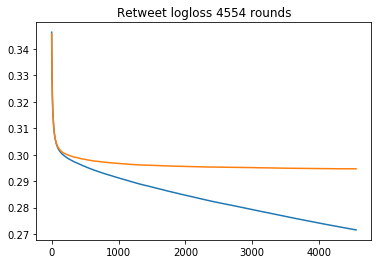

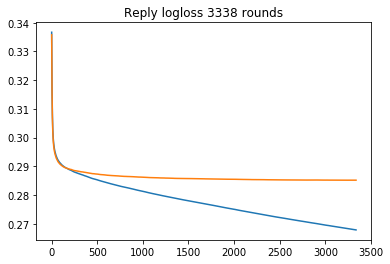

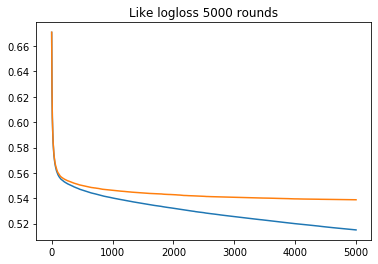

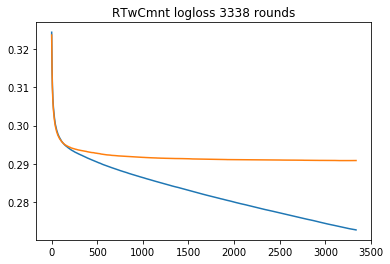

In [10]:
for tgt in tgt2evlres:
    evlres=tgt2evlres[tgt]
    plt.plot(evlres['training']['binary_logloss'])
    plt.plot(evlres['valid_1']['binary_logloss'])
    plt.title(f"{tgt} logloss {len(evlres['valid_1']['binary_logloss'])} rounds")
    plt.show()

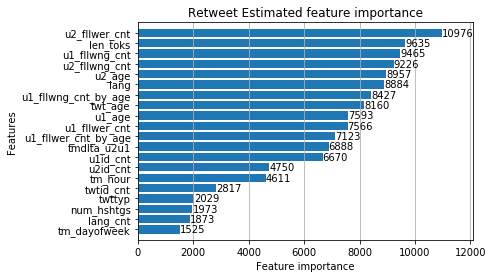

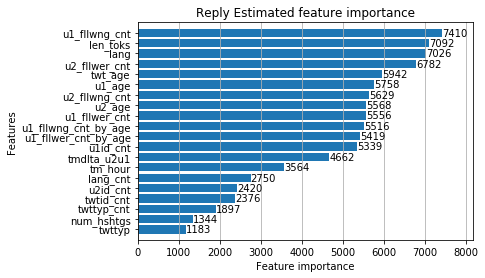

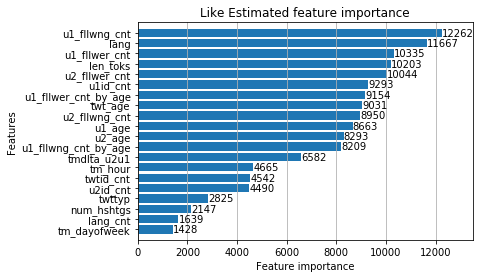

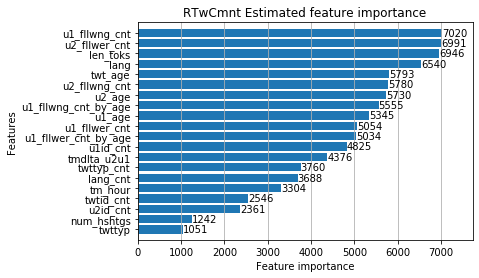

In [11]:
def show_feat_importance(tgt):
    bst=tgt2bst[tgt]
    ax = lgb.plot_importance(bst, height=0.8, max_num_features=20)
    ax.grid(False, axis="y")
    ax.set_title(f'{tgt} Estimated feature importance')
    plt.show()
#     feat2importance=bst.get_fscore()
#     print(tgt)
#     display(pd.DataFrame([feat2importance.keys(), 
#                           feat2importance.values()]).T.sort_values(1, ascending=False))

for tgt in tgt2bst:
    show_feat_importance(tgt)

In [12]:
tgt2auc_tr={}
tgt2rce_tr={}
tgt2auc_vl={}
tgt2rce_vl={}
for tgt in tgt2bst:
    print(tgt)
    prdtr_i, prdvl_i = tgt2prdtr[tgt], tgt2prdvl[tgt]
    ytr_i, yvl_i = tgt2ytr[tgt], tgt2yvl[tgt]
    scr_auc_tr=compute_prauc(prdtr_i, ytr_i)
    scr_rce_tr=compute_rce(prdtr_i, ytr_i)
    scr_auc_vl=compute_prauc(prdvl_i, yvl_i)
    scr_rce_vl=compute_rce(prdvl_i, yvl_i)

    tgt2auc_tr[tgt]=scr_auc_tr
    tgt2rce_tr[tgt]=scr_rce_tr
    tgt2auc_vl[tgt]=scr_auc_vl
    tgt2rce_vl[tgt]=scr_rce_vl
    
    print('tr prauc:', f'{scr_auc_tr:.4f}','tr rce:', f'{scr_rce_tr:.4f}', )
    print('vl prauc:', f'{scr_auc_vl:.4f}','vl rce:', f'{scr_rce_vl:.4f}', )

Retweet
tr prauc: 0.4699 tr rce: 22.9685
vl prauc: 0.3802 vl rce: 16.4290
Reply
tr prauc: 0.4204 tr rce: 22.4322
vl prauc: 0.3436 vl rce: 17.3720
Like
tr prauc: 0.7866 tr rce: 24.8903
vl prauc: 0.7574 vl rce: 21.4309
RTwCmnt
tr prauc: 0.3564 tr rce: 16.7425
vl prauc: 0.2650 vl rce: 11.1822


In [13]:
lsttr=[]
lstvl=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    if tgt not in tgt2bst: continue
    lsttr+=[(f'PRAUC {tgt}',tgt2auc_tr[tgt]),
          (f'RCE {tgt}',tgt2rce_tr[tgt])]
    lstvl+=[(f'PRAUC {tgt}',tgt2auc_vl[tgt]),
          (f'RCE {tgt}',tgt2rce_vl[tgt])]

dfscrtr=pd.DataFrame(lsttr)
dfscrtr.columns=['metric','scr']
dfscrvl=pd.DataFrame(lstvl)
dfscrvl.columns=['metric','scr']
dfscr = pd.merge(dfscrtr, dfscrvl, on='metric', suffixes=('tr','vl'))
dfscr.T

,0,1,2,3,4,5,6,7
metric,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RTwCmnt,RCE RTwCmnt
scrtr,0.469904,22.9685,0.420418,22.4322,0.786555,24.8903,0.356395,16.7425
scrvl,0.38016,16.429,0.34364,17.372,0.757423,21.4309,0.264968,11.1822


## valid

In [14]:
# tgt=tgts[1]
# tgtcol=tgt2col[tgt]
# bst=tgt2bst[tgt]

# dvalid=xgb.DMatrix(dfvalid[cols_feat], label=dfvalid[tgtcol], feature_names=cols_feat)

# prdvalid = bst.predict(dvalid, ntree_limit=bst.best_ntree_limit)

# pops=tgt2pops[tgt]

# prdvalid[:10]
# # array([0.11734424, 0.09971393, 0.05619054, 0.03059793, 0.07979691,
# #        0.01358252, 0.05293725, 0.27954698, 0.05738379, 0.01741553],
# #       dtype=float32)


# pops
# # {'train_pop': 4000000,
# #  'target_pop': 109752,
# #  'sampled_train_pop': 1000000,
# #  'sampled_target_pop': 109752}

# prdvalid_calib = calibration(prdvalid, **pops)

# prdvalid_calib[:10]
# # array([0.02952491, 0.02471944, 0.01344113, 0.00717127, 0.01945818,
# #        0.00314114, 0.0126298 , 0.08155248, 0.01373977, 0.00403964],
# #       dtype=float32)

In [15]:
tgt2pops

{'Retweet': {'train_pop': 5000000,
  'target_pop': 565774,
  'sampled_train_pop': 5000000,
  'sampled_target_pop': 565774},
 'Reply': {'train_pop': 20000000,
  'target_pop': 548412,
  'sampled_train_pop': 5000000,
  'sampled_target_pop': 548412},
 'Like': {'train_pop': 5000000,
  'target_pop': 2195574,
  'sampled_train_pop': 5000000,
  'sampled_target_pop': 2195574},
 'RTwCmnt': {'train_pop': 65000000,
  'target_pop': 506880,
  'sampled_train_pop': 5000000,
  'sampled_target_pop': 506880}}

In [16]:
def do_post_valid(tgt):
    tgtcol=tgt2col[tgt]
    bst=tgt2bst[tgt]
    pops=tgt2pops[tgt]
    prdvalid = bst.predict(dfvalid[cols_feat],num_iteration=bst.best_iteration)
    prdvalid_calib = calibration(prdvalid, **pops)
    return prdvalid,prdvalid_calib

In [17]:
tgt2yvalid={tgt:dfvalid[tgt2col[tgt]] for tgt in tgts}
tgt2prdvalid={}
tgt2prdvalid_calib={}
for tgt in tgts:
    print(dtnow(), tgt)
    tgt2prdvalid[tgt],tgt2prdvalid_calib[tgt]=do_post_valid(tgt)


2020-03-25 04:52:06 Retweet
2020-03-25 04:54:22 Reply
2020-03-25 04:56:08 Like
2020-03-25 04:58:38 RTwCmnt


In [18]:
tgt2auc_valid={}
tgt2rce_valid={}
tgt2auc_valid_calib={}
tgt2rce_valid_calib={}
for tgt in tgts:
    print(dtnow(), tgt)
    prdvalid, prdvalid_calib = tgt2prdvalid[tgt], tgt2prdvalid_calib[tgt]
    yvalid = tgt2yvalid[tgt]
    scr_auc_valid=compute_prauc(prdvalid, yvalid)
    scr_rce_valid=compute_rce(prdvalid, yvalid)
    scr_auc_valid_calib=compute_prauc(prdvalid_calib, yvalid)
    scr_rce_valid_calib=compute_rce(prdvalid_calib, yvalid)

    tgt2auc_valid[tgt]=scr_auc_valid
    tgt2rce_valid[tgt]=scr_rce_valid
    tgt2auc_valid_calib[tgt]=scr_auc_valid_calib
    tgt2rce_valid_calib[tgt]=scr_rce_valid_calib

2020-03-25 05:00:23 Retweet
2020-03-25 05:00:41 Reply
2020-03-25 05:00:56 Like
2020-03-25 05:01:13 RTwCmnt


In [19]:
for tgt in tgts:
    print(tgt)
    print('tr          prauc:', f'{tgt2auc_tr[tgt]:.4f}','tr rce:', f'{tgt2rce_tr[tgt]:.4f}', )
    print('vl          prauc:', f'{tgt2auc_vl[tgt]:.4f}','tr rce:', f'{tgt2rce_vl[tgt]:.4f}', )
    print('valid       prauc:', f'{tgt2auc_valid[tgt]:.4f}','tr rce:', f'{tgt2rce_valid[tgt]:.4f}', )
    print('valid_calib prauc:', f'{tgt2auc_valid_calib[tgt]:.4f}','tr rce:', f'{tgt2rce_valid_calib[tgt]:.4f}', )
    

Retweet
tr          prauc: 0.4699 tr rce: 22.9685
vl          prauc: 0.3802 tr rce: 16.4290
valid       prauc: 0.3666 tr rce: 15.7039
valid_calib prauc: 0.3666 tr rce: 15.7039
Reply
tr          prauc: 0.4204 tr rce: 22.4322
vl          prauc: 0.3436 tr rce: 17.3720
valid       prauc: 0.1167 tr rce: -20.5094
valid_calib prauc: 0.1167 tr rce: 13.2837
Like
tr          prauc: 0.7866 tr rce: 24.8903
vl          prauc: 0.7574 tr rce: 21.4309
valid       prauc: 0.7533 tr rce: 21.0595
valid_calib prauc: 0.7533 tr rce: 21.0595
RTwCmnt
tr          prauc: 0.3564 tr rce: 16.7425
vl          prauc: 0.2650 tr rce: 11.1822
valid       prauc: 0.0294 tr rce: -154.5421
valid_calib prauc: 0.0294 tr rce: 7.0408


In [20]:
lsttr=[]
lstvl=[]
lstvalid=[]
lstvalid_calib=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    if tgt not in tgt2bst: continue
    lsttr+=[(f'PRAUC {tgt}',tgt2auc_tr[tgt]),
          (f'RCE {tgt}',tgt2rce_tr[tgt])]
    lstvl+=[(f'PRAUC {tgt}',tgt2auc_vl[tgt]),
          (f'RCE {tgt}',tgt2rce_vl[tgt])]
    lstvalid+=[(f'PRAUC {tgt}',tgt2auc_valid[tgt]),
          (f'RCE {tgt}',tgt2rce_valid[tgt])]
    lstvalid_calib+=[(f'PRAUC {tgt}',tgt2auc_valid_calib[tgt]),
          (f'RCE {tgt}',tgt2rce_valid_calib[tgt])]

dfscrtr=pd.DataFrame(lsttr)
dfscrtr.columns=['metric','scr']
dfscrvl=pd.DataFrame(lstvl)
dfscrvl.columns=['metric','scr']
dfscrvalid=pd.DataFrame(lstvalid)
dfscrvalid.columns=['metric','scr']
dfscrvalid_calib=pd.DataFrame(lstvalid_calib)
dfscrvalid_calib.columns=['metric','scr']

dfscr = reduce(lambda df1,df2: pd.merge(df1,df2,on='metric'), 
            [dfscrtr,dfscrvl,dfscrvalid,dfscrvalid_calib])

dfscr.columns=['scr','tr','vl','valid','valid_calib']
dfscr.T

,0,1,2,3,4,5,6,7
scr,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RTwCmnt,RCE RTwCmnt
tr,0.469904,22.9685,0.420418,22.4322,0.786555,24.8903,0.356395,16.7425
vl,0.38016,16.429,0.34364,17.372,0.757423,21.4309,0.264968,11.1822
valid,0.366606,15.7039,0.116719,-20.5094,0.753294,21.0595,0.0294245,-154.542
valid_calib,0.366606,15.7039,0.116719,13.2837,0.753294,21.0595,0.0294245,7.04082


# infer

In [21]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{valtmstmp}.tsv',
#     f'{p_in}/val_259A6F6DFD672CB1F883CBEC01B99F2D_1584405047.tsv',
    sep='\x01', header=None, names=cols_val,)


CPU times: user 2min 31s, sys: 4.32 s, total: 2min 36s
Wall time: 2min 47s


In [22]:
%%time
dftst = prp_df(dftst, istrn=False)

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


CPU times: user 5min 28s, sys: 1min 9s, total: 6min 38s
Wall time: 6min 52s


In [23]:
%%time
tgt2prdtst={}
for tgt in tgts:
    print(dtnow(), tgt)
    bst = tgt2bst[tgt]
    pops=tgt2pops[tgt]
    prdtst = bst.predict(dftst[cols_feat], num_iteration=bst.best_iteration)
    prdtst_calib = calibration(prdtst, **pops)
    tgt2prdtst[tgt] = prdtst_calib

2020-03-25 05:11:09 Retweet
2020-03-25 05:17:49 Reply
2020-03-25 05:23:22 Like
2020-03-25 05:30:41 RTwCmnt
CPU times: user 5h 16min 54s, sys: 1min 44s, total: 5h 18min 38s
Wall time: 24min 53s


In [24]:
dfsub_ids = dftst[['twtid','u2id',]]

tgt2dfsub = {}
for tgt,prdtst in tgt2prdtst.items():
    dfsub = dfsub_ids.copy()
    dfsub['scr'] = prdtst
    tgt2dfsub[tgt]=dfsub

In [25]:
%%time
for i,tgt in enumerate(['Retweet','Reply','RTwCmnt','Like',]):
    dfsub = tgt2dfsub[tgt]
    print(dtnow(), tgt)
    dfsub.to_csv(f'{p_out}/{i}_{tgt}__{valtmstmp}__{PRFX}.csv',index=False,header=False)

2020-03-25 05:36:09 Retweet
2020-03-25 05:38:19 Reply
2020-03-25 05:40:25 RTwCmnt
2020-03-25 05:42:17 Like
CPU times: user 7min 29s, sys: 21.6 s, total: 7min 50s
Wall time: 8min 14s
